<img src="logo3.jpg" style="float:left; max-width: 150px; margin-right: 20px;">
<div style="clear:left; text-align:center; font-family: Didot, serif;">
    <h1 style="font-size:25px;">Université Toulouse III - Paul Sabatier</h1>
    <p style="text-align:center; font-size:25px;">UE: Calcul scientifique et apprentissage automatique</p>
    <p style="text-align:center; font-size:20px;">Master 1 IAFA</p>
    <p style="font-size:20px;">Réalisé par : Nouh Chelgham et Noura Faiz </p>
</div>

<h3 style="text-align:center;font-family: Didot, serif; font-size:25px;color:#00008B;">Classification de battements cardiaques</h3>





<img src="files/BattementCardiaque.PNG" width="600" height="300"  >

Cet ensemble de données a été créé à l'origine pour un défi d'apprentissage automatique visant à classer les bruits de battements cardiaques.

Les données ont été recueillies auprès de deux sources :
- (A) auprès du grand public via une application de smartphone,
- (B) dans le cadre d'un essai clinique dans des hôpitaux utilisant le stéthoscope numérique.


Les enregistrements de ces 2 sources étant de durées différentes, ils ont été ensuite transformés en MFCC pour extraire le contenu fréquentiel de ces données.


In [168]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import librosa
import IPython.display as ipd

import matplotlib.pyplot as plt
import sklearn
import math
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import seaborn as sns



## Exemples de sons de l'ensemble A de battements cardiaques à classer



In [2]:
# Son d'un battement normal
x0,sr0=librosa.load("normalA.wav",duration=5)
ipd.Audio(x0,rate=sr0)


In [3]:
# Son d'un murmure cardiaque

x1,sr1=librosa.load("murmurA.wav",duration=5)
ipd.Audio(x1,rate=sr1)

In [4]:
# Son d'un artefact
x3,sr3=librosa.load("artifactA.wav",duration=5)
ipd.Audio(x3,rate=sr3)

## Exemples de sons de l'ensemble B de battements cardiaques à classer



In [5]:
# Son d'un battement normal - ensemble B
x4,sr4=librosa.load("normalB.wav",duration=5)
ipd.Audio(x4,rate=sr4)


In [6]:
# Son d'un murmure cardiaque - ensemble B

x5,sr5=librosa.load("murmurB.wav",duration=5)
ipd.Audio(x5,rate=sr5)

<h2 style="font-family: Didot, serif;">1. Préparation des données:</h2></span>
<h3 style="color:#00008B; font-family: Didot, serif;">1.1. Chargement des données </h3>

A chaque enregistrement, 20 coefficients MFCC sont calculés en réalisant la moyenne sur chaque fenêtre de 10ms.

*DataMFCC.csv* regroupe tous les enregistrements des 2 dispositifs.

Le fichier source *DataMFCC.csv* sur lequel vous travaillez est la conversion des enregistrements audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel du signal audio.

La matrice de données est composée d'autant de vecteurs lignes que de fichiers audio. Le nombre de colonnes correspond à la dimension du vecteur moyen représentatif des MFCC : ici 20.

In [7]:
data = pd.read_csv('DataMFCC.csv')

data.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,label
0,-489.62180,70.23919,61.142830,48.898050,36.555330,26.469486,19.623278,15.663741,13.472218,11.869776,...,8.004507,5.803412,3.905093,2.625853,2.056817,2.049077,2.306891,2.535396,2.566249,normal
1,-406.42853,153.23886,-1.369525,16.263828,10.937109,16.939487,4.494656,6.633343,6.228123,3.696192,...,-2.162616,-0.629793,-0.598225,-1.809965,-2.767086,-3.141027,-3.952870,-3.527147,-4.081270,normal
2,-511.58224,82.09152,6.478385,35.782322,4.926917,23.501286,2.172139,16.772097,-0.364136,12.615507,...,10.425499,-2.136471,6.526673,-2.714465,4.534374,-2.864164,2.395745,-2.710135,1.320221,normal
3,-514.13293,78.29218,65.463070,49.305313,34.505836,23.954039,18.073490,15.343872,13.722630,11.918728,...,7.061982,4.627193,2.702706,1.549387,1.235011,1.578198,2.168477,2.570371,2.564390,normal
4,-371.67172,155.28653,35.827470,19.501045,37.935867,34.704395,17.897236,9.181622,10.555704,10.437612,...,-0.750443,2.518559,6.119143,1.359976,-3.627311,-3.266012,0.071095,0.160198,-1.439477,normal


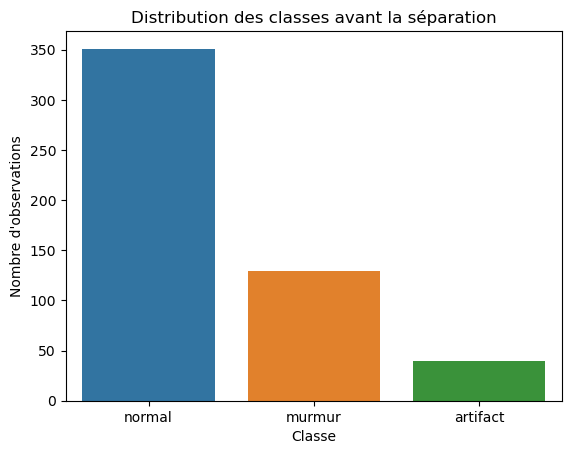

In [53]:
# Comptage des occurrences de chaque classe
class_counts = data['label'].value_counts()

# Création du graphique en barres
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.title('Distribution des classes avant la séparation')
plt.show()


In [9]:
X=data.iloc[:,0:20]
X.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19
0,-489.62180,70.23919,61.142830,48.898050,36.555330,26.469486,19.623278,15.663741,13.472218,11.869776,10.107503,8.004507,5.803412,3.905093,2.625853,2.056817,2.049077,2.306891,2.535396,2.566249
1,-406.42853,153.23886,-1.369525,16.263828,10.937109,16.939487,4.494656,6.633343,6.228123,3.696192,-3.058978,-2.162616,-0.629793,-0.598225,-1.809965,-2.767086,-3.141027,-3.952870,-3.527147,-4.081270
2,-511.58224,82.09152,6.478385,35.782322,4.926917,23.501286,2.172139,16.772097,-0.364136,12.615507,-1.403247,10.425499,-2.136471,6.526673,-2.714465,4.534374,-2.864164,2.395745,-2.710135,1.320221
3,-514.13293,78.29218,65.463070,49.305313,34.505836,23.954039,18.073490,15.343872,13.722630,11.918728,9.623236,7.061982,4.627193,2.702706,1.549387,1.235011,1.578198,2.168477,2.570371,2.564390
4,-371.67172,155.28653,35.827470,19.501045,37.935867,34.704395,17.897236,9.181622,10.555704,10.437612,2.700969,-0.750443,2.518559,6.119143,1.359976,-3.627311,-3.266012,0.071095,0.160198,-1.439477


<h3 style="color:#2F4F4F; font-family: Didot, serif;">a. Encodage des Labels de Classe en Chiffrese </h3>

In [10]:
ylabel=data["label"]
le=LabelEncoder().fit(ylabel)
y=le.transform(ylabel)

print('Label',ylabel[40],'correspond au numero',y[40])
print('Label',ylabel[0],'correspond au numero',y[0])
print('Label',ylabel[100],'correspond au numero',y[100])


Label artifact correspond au numero 0
Label normal correspond au numero 2
Label murmur correspond au numero 1


<h3 style="color:#2F4F4F; font-family: Didot, serif;">b. Création de la base d'Apprentissage et de Test </h3> 

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=31,stratify=y)

print("Base d'apprentissage - X_Train: ",len(X_train),"\n","Base de test - X_Test: ",len(X_test),sep="")

Base d'apprentissage - X_Train: 390
Base de test - X_Test: 130


<h3 style="color:#2F4F4F; font-family: Didot, serif;">c. Description de l'ensemble d'Apprentissage </h3> 

In [18]:
values,count=np.unique(y_train, return_counts=True)
print('label:',values,'nbre de valeurs:',count )

label: [0 1 2] nbre de valeurs: [ 30  97 263]


<h3 style="color:#00008B; font-family: Didot, serif;">1.2. Création de Table de Correspondance : Labels Non Supervisés vs Labels Réels </h3>

In [19]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label 
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels

<h2 style="font-family: Didot, serif;">2. Méthodes d'apprentissage supervisé:</h2></span> 
<h3 style="color:#00008B; font-family: Didot, serif;">1. Méthode supervisée (KNN : k nearest neighbors) : </h3>
<h3 style="color:#2F4F4F; font-family: Didot, serif;">a. Algorithme </h3>  

Le KNN est un algorithme de classification supervisé. Pour chaque observation $x_{i}=(x^{1}_{i}, x^{1}_{i}, x^{2}_{i}, ... x^{n}_{i}) $ , nous avons une étiquette associée $y_{i}$, qui représente la classe de $x_{i}$.

Pour classer un nouveau vecteur \( x \) à l'aide de KNN :

1. Calculez la distance (souvent euclidienne, mais d'autres métriques peuvent être utilisées) entre x  et chaque échantillon  $x_{i}$ dans l'ensemble d'entraînement.
2. Identifiez les k  échantillons  $x_{i}$ les plus proches de x .
3. La classe attribuée à x  sera celle qui est majoritairement représentée parmi ces k  voisins les plus proches.

<h3 style="color:#2F4F4F; font-family: Didot, serif;">b. Visualisation des Données Graphiques </h3>  

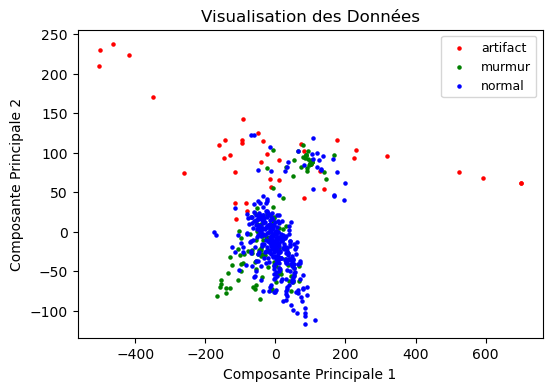

In [22]:
def plot_blobs(X, y, title="Visualisation des Données"):
    plt.figure(figsize=(6, 4))
    plt.scatter(X[np.where(y == 0), 0], X[np.where(y == 0), 1], s=5, color='r', label="artifact")
    plt.scatter(X[np.where(y == 1), 0], X[np.where(y == 1), 1], s=5, color='g', label="murmur")
    plt.scatter(X[np.where(y == 2), 0], X[np.where(y == 2), 1], s=5, color='b', label="normal")
    plt.legend(loc=0, prop={'size': 9})
    plt.title(title)
    plt.xlabel("Composante Principale 1")
    plt.ylabel("Composante Principale 2")

# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Tracé des données réduites
plot_blobs(X_reduced, y)
plt.show()



In [23]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
X_train_np = np.ascontiguousarray(X_train_np)
X_test_np = np.ascontiguousarray(X_test_np)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

accuracys = []
cms = []
for i in range(1, 13, 2):
    neight = KNeighborsClassifier(n_neighbors=i)
    neight.fit(X_train_np, y_train)
    y_pred = neight.predict(X_test_np)
    accuracys.append(accuracy_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))

<h3 style="color:#2F4F4F; font-family: Didot, serif;">c.Visualisation de la Matrice de Confusion </h3>  

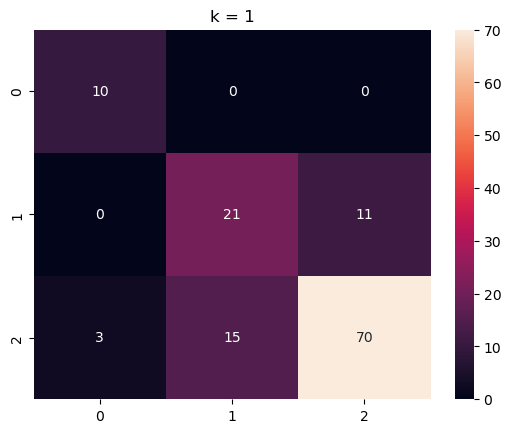

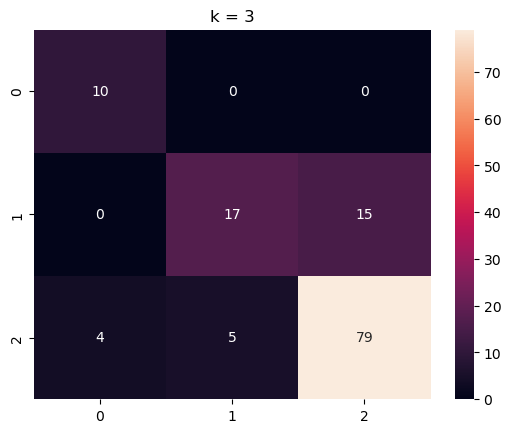

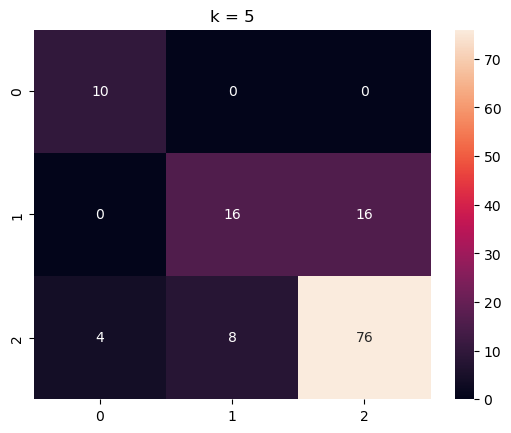

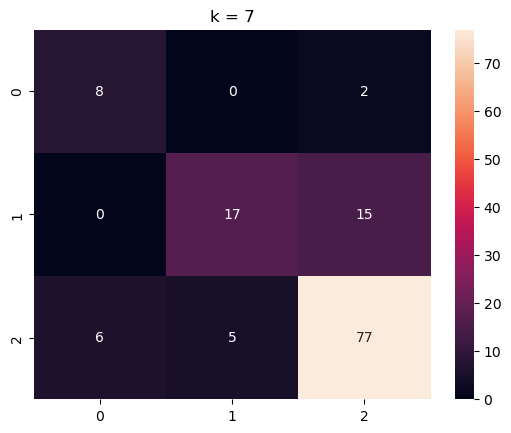

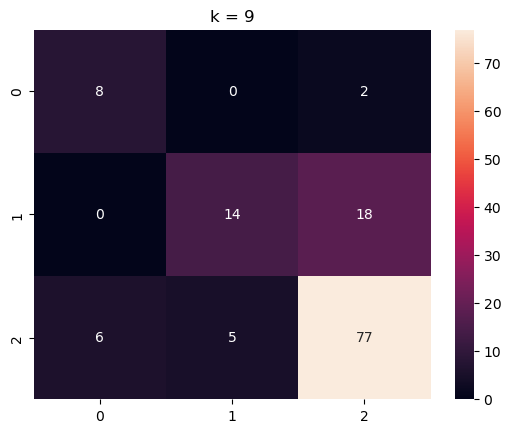

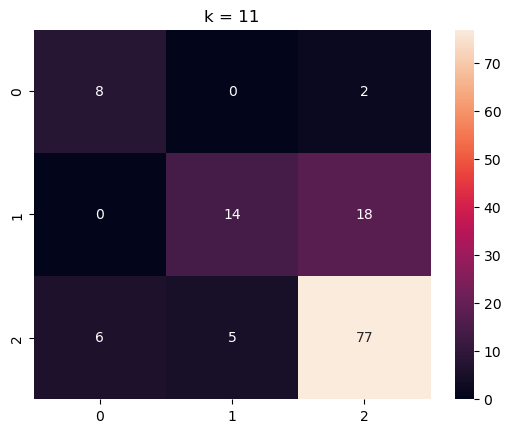

In [25]:
for i in range(len(cms)):
    plt.title("k = "+str(i+(i+1%2)))
    sns.heatmap(cms[i],annot=True,fmt="d")
    plt.show()

<h3 style="color:#2F4F4F; font-family: Didot, serif;">d. Performance du Modèle k-NN : Précision selon k</h3>  

In [26]:
K = {}
for i in range(len(accuracys)):
    K[ i+(i+1%2) ] = accuracys[i]
    print("k = {} \t | \t accuracy = {}".format(str(i+(i+1%2)),accuracys[i]))

k = 1 	 | 	 accuracy = 0.7769230769230769
k = 3 	 | 	 accuracy = 0.8153846153846154
k = 5 	 | 	 accuracy = 0.7846153846153846
k = 7 	 | 	 accuracy = 0.7846153846153846
k = 9 	 | 	 accuracy = 0.7615384615384615
k = 11 	 | 	 accuracy = 0.7615384615384615


<h3 style="color:#2F4F4F; font-family: Didot, serif;">e. Optimisation de la Valeur de k : Courbe de Précision et Sélection du Modèle</h3>  

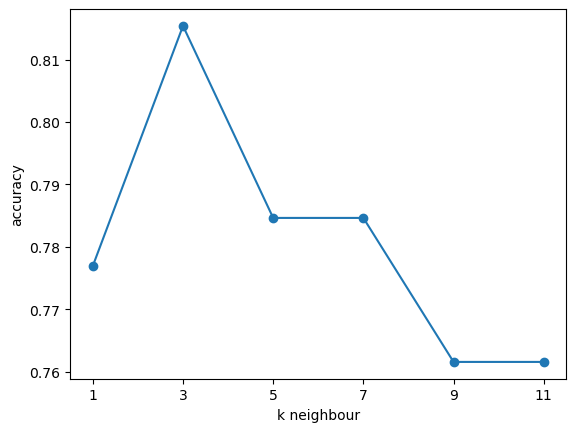

In [28]:
plt.plot(np.arange(1,13,2),np.array(accuracys),marker="o")
plt.xticks(np.arange(1, 13,2))
plt.xlabel('k neighbour')
plt.ylabel('accuracy')
plt.show()

In [30]:
def get_max_K(K):
    max_value = max(K.values())
    max_keys = [k for k, v in K.items() if v == max_value]
    return max_keys[0]

print("la valeur optimale de k pour ce probleme est: ",get_max_K(K))

la valeur optimale de k pour ce probleme est:  3


<h3 style="color:#00008B; font-family: Didot, serif;">2. Méthode supervisée (SVM : Support Vector Machines): </h3>
<h3 style="color:#2F4F4F; font-family: Didot, serif;">a. Algorithme </h3>  

Le SVM est un algorithme de classification supervisé qui cherche à trouver l'hyperplan qui maximise la marge entre les deux classes. Pour chaque observation $( x_i = (x_{i}^{1}, x_{i}^{2}, \ldots, x_{i}^{n}) )$, nous avons une étiquette associée $( y_i )$, qui représente la classe de $( x_i )$.

Pour classer un nouveau vecteur \( x \) à l'aide de SVM :

1. Construisez un hyperplan ou un ensemble d'hyperplans dans un espace de dimension élevée ou infinie.
2. Choisissez l'hyperplan qui maximise la marge entre les classes d'entraînement.
3. La classe attribuée à \( x \) sera celle qui est de l'autre côté de la marge par rapport à l'hyperplan.



In [35]:
# Création du modèle SVM avec un noyau linéaire
svm_model = SVC(kernel='linear', random_state=42)

# Entraînement du modèle SVM
svm_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Précision du SVM:", accuracy_svm)

# Calcul de la matrice de confusion
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

Précision du SVM: 0.8


<h3 style="color:#2F4F4F; font-family: Didot, serif;">b.Visualisation de la Matrice de Confusion </h3>

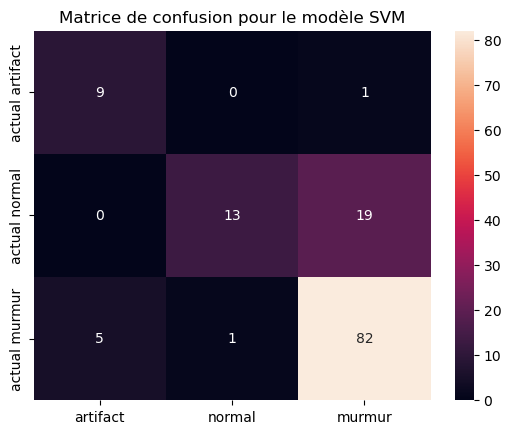

In [36]:
class_labelsX = ['artifact', 'normal', 'murmur']
class_labelsY = ['actual artifact', 'actual normal', 'actual murmur']

plt.title('Matrice de confusion pour le modèle SVM')
sns.heatmap(conf_matrix_svm,annot=True,fmt="d" , xticklabels=class_labelsX, yticklabels=class_labelsY)
plt.show()


<h3 style="color:#00008B; font-family: Didot, serif;">3. Méthode supervisée (Random Forest): </h3>
<h3 style="color:#2F4F4F; font-family: Didot, serif;">a. Algorithme </h3>  

Le Random Forest est un algorithme d'apprentissage supervisé qui fonctionne en construisant un ensemble de décision d'arbres lors de la phase d'entraînement et en sortant le mode des classes (classification) ou une prédiction moyenne (régression) des arbres individuels. Pour chaque observation $( x_i )$, nous avons une étiquette associée $( y_i )$, qui représente la classe ou la valeur cible de $( x_i )$.

Pour faire une prédiction pour un nouveau vecteur $( x )$ à l'aide de Random Forest :

1. Chaque arbre dans l'ensemble est construit à partir d'un échantillon tiré avec remplacement (c'est-à-dire, un échantillon bootstrap) de l'ensemble d'entraînement.
2. Lors de la construction de ces arbres, un sous-ensemble aléatoire de caractéristiques est sélectionné pour la division à chaque nœud.
3. Pour la prédiction, chaque arbre vote et la classe (ou la valeur) la plus votée est choisie comme prédiction finale de l'ensemble.

In [40]:
# Création du modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle Random Forest
rf_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)


In [41]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Précision de la Random Forest:", accuracy_rf)

# Calcul de la matrice de confusion
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)


Précision de la Random Forest: 0.823076923076923


<h3 style="color:#2F4F4F; font-family: Didot, serif;">b.Visualisation de la Matrice de Confusion </h3>

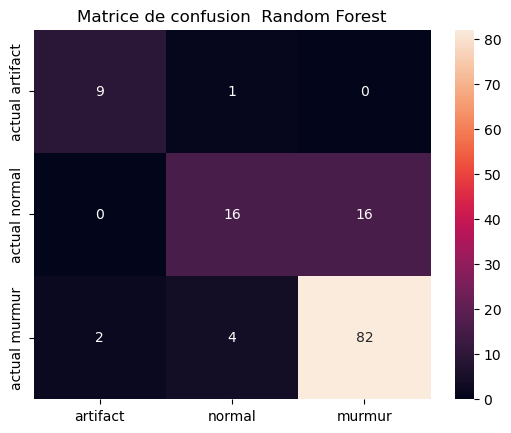

In [42]:
#labels des axis X / Y
class_labelsX = ['artifact', 'normal', 'murmur']
class_labelsY = ['actual artifact', 'actual normal', 'actual murmur']


plt.title('Matrice de confusion  Random Forest')
sns.heatmap(conf_matrix_rf,annot=True,fmt="d" ,xticklabels=class_labelsX, yticklabels=class_labelsY )
plt.show()


<h2 style="font-family: Didot, serif;">2. Méthode non supervisée:</h2></span> 
<h3 style="color:#00008B; font-family: Didot, serif;">1. Méthode non supervisée (K-Means) : </h3>
<h3 style="color:#2F4F4F; font-family: Didot, serif;">a. Algorithme </h3>  

Le K-Means est un algorithme d'apprentissage non supervisé utilisé pour la classification non supervisée (clustering). L'objectif est de diviser $n$ observations en $k$ clusters dans lesquels chaque observation appartient au cluster avec la moyenne la plus proche.

Les étapes de l'algorithme K-Means sont les suivantes :

1. Choisissez $k$ points comme centres de clusters initiaux (centroïdes).
2. Attribuez chaque observation au centroïde le plus proche, formant $k$ clusters.
3. Recalculez les centroïdes de chaque cluster en prenant la moyenne de toutes les observations qui y sont attribuées.
4. Répétez les étapes 2 et 3 jusqu'à ce que les centroïdes ne changent plus significativement, indiquant que les clusters sont stables.

La fonction objectif est minimisée :

$$[ J = \sum_{i=1}^{k} \sum_{x \in S_i} \| x - \mu_i \|^2 ]$$

où $( J )$ est la somme des carrés des distances de chaque point à son centroïde $( \mu_i $), et $( S_i)$ est l'ensemble des points dans le i-ème cluster.

In [45]:
# On fixe le nombre de clusters au nombre d'étiquettes uniques dans notre ensemble de données
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

#ajuster le modèle et obtenir les clusters
y_pred = kmeans.fit_predict(X)

#obtenir une correspondance entre les clusters de K-means et les véritables étiquettes
y_pred_label = correspondance(y_pred, y)


C:\Users\faizn_h\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\faizn_h\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [46]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y, y_pred_label)
# Calcul du score de précision
accuracy = accuracy_score(y, y_pred_label)


<h3 style="color:#2F4F4F; font-family: Didot, serif;">b.Visualisation de la Matrice de Confusion </h3>

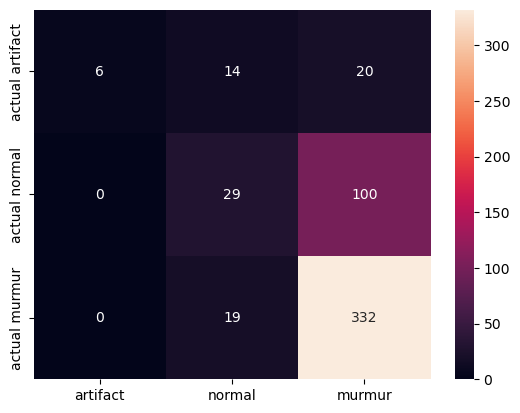


Score de précision : 0.7057692307692308


In [127]:
class_labelsX = ['artifact', 'normal', 'murmur']
class_labelsY = ['actual artifact', 'actual normal', 'actual murmur']

sns.heatmap(cm,annot=True,fmt="d" , xticklabels=class_labelsX, yticklabels=class_labelsY )
plt.show()

print("\nScore de précision :", accuracy)


<h2 style="font-family: Didot, serif;">II. Rééquilibrage des Données et Réimplémentation des Méthodes de Classification:</h2></span> 
<h3 style="color:#00008B; font-family: Didot, serif;">1. Équilibrage des Données par Sous-échantillonnage  </h3>

Le sous-échantillonnage est une technique de prétraitement des données pour les ensembles de données déséquilibrés. Considérons un ensemble de données avec des classes $( C_1, C_2, \ldots, C_n )$, où chaque classe $( C_i )$ a un nombre d'observations $( n_i )$.

Pour appliquer le sous-échantillonnage :

1. Identifiez la classe avec le moins d'observations, notée par son nombre d'observations $( n_{\text{min}} )$, tel que $( n_{\text{min}} = \min(n_1, n_2, \ldots, n_n) )$.
2. Pour chaque classe $( C_i )$ avec $( n_i > n_{\text{min}} )$, effectuez un échantillonnage aléatoire pour sélectionner $( n_{\text{min}} )$ observations.
3. La nouvelle distribution des classes $( C_i)$ aura alors un nombre d'observations égal ou inférieur à $( n_{\text{min}} )$, conduisant à un ensemble de données équilibré.



In [128]:
# Nombre d'observations dans la classe la moins représentée
n_artifact = data[data['label'] == 'artifact'].shape[0]

# Sous-échantillonnage de la classe 'normal'
data_normal_sampled = data[data['label'] == 'normal'].sample(n=n_artifact, random_state=10)

# Sous-échantillonnage de la classe 'murmur' si nécessaire
data_murmur_sampled = data[data['label'] == 'murmur'].sample(n=n_artifact, random_state=10)

# Combinez les sous-ensembles équilibrés en un seul DataFrame
data_balanced = pd.concat([data_normal_sampled, data_murmur_sampled, data[data['label'] == 'artifact']])

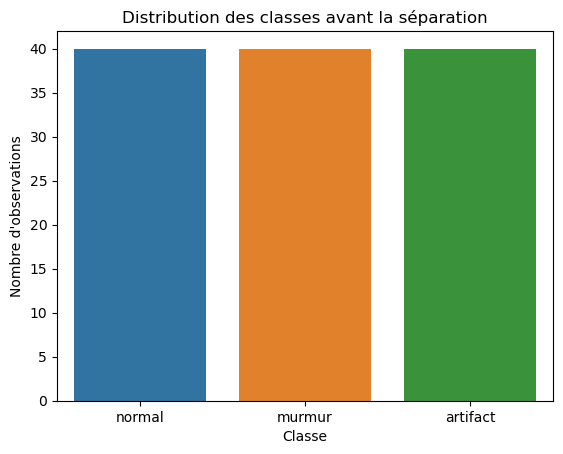

In [129]:
# Comptage des occurrences de chaque classe
class_counts = data_balanced['label'].value_counts()

# Création du graphique en barres
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.title('Distribution des classes avant la séparation')
plt.show()

In [130]:
eq_X=data_balanced.iloc[:,0:20]
# Encode le label de chaque classe par un chiffre
eq_ylabe=data_balanced["label"]
eq_le=LabelEncoder().fit(eq_ylabe)
eq_y=eq_le.transform(eq_ylabe)

In [131]:
Eq_Xtrain,Eq_Xtest,Eq_ytrain,Eq_ytest=train_test_split(eq_X,eq_y,test_size=0.25,random_state=31,stratify=eq_y)

In [132]:
# Description de l'ensemble d'apprentissage
Eq_values,Eq_count=np.unique(Eq_ytrain, return_counts=True)

print('label:',Eq_values,'nbre de valeurs:',Eq_count )

label: [0 1 2] nbre de valeurs: [30 30 30]



<h3 style="color:#00008B; font-family: Didot, serif;">2.1 Méthode supervisée (KNN : k nearest neighbors) : </h3> 

In [133]:
Eq_Xtrain_np = Eq_Xtrain.to_numpy()
Eq_Xtest_np = Eq_Xtest.to_numpy()
Eq_Xtrain_np = np.ascontiguousarray(Eq_Xtrain_np)
Eq_Xtest_np = np.ascontiguousarray(Eq_Xtest_np)

Eq_accuracys = []
Eq_cms = []
for i in range(1, 13, 2):
    Eq_neight = KNeighborsClassifier(n_neighbors=i)
    Eq_neight.fit(Eq_Xtrain_np, Eq_ytrain)
    Eq_ypred = neight.predict(Eq_Xtest_np)
    Eq_accuracys.append(accuracy_score(Eq_ytest, Eq_ypred))
    Eq_cms.append(confusion_matrix(Eq_ytest, Eq_ypred))

<h3 style="color:#2F4F4F; font-family: Didot, serif;">a.Visualisation de la Matrice de Confusion </h3> 

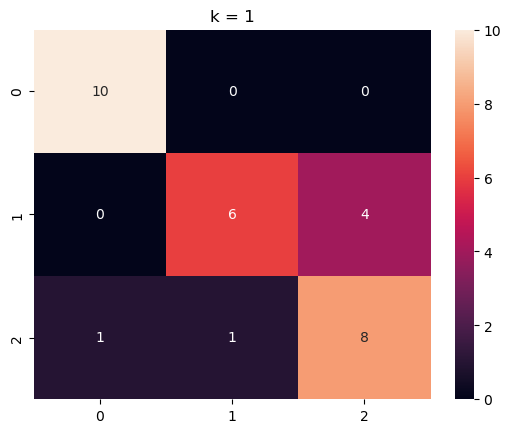

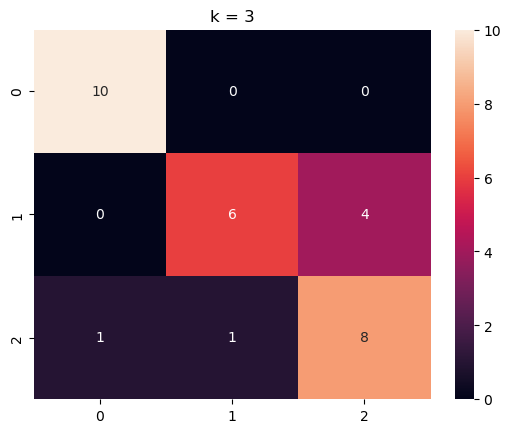

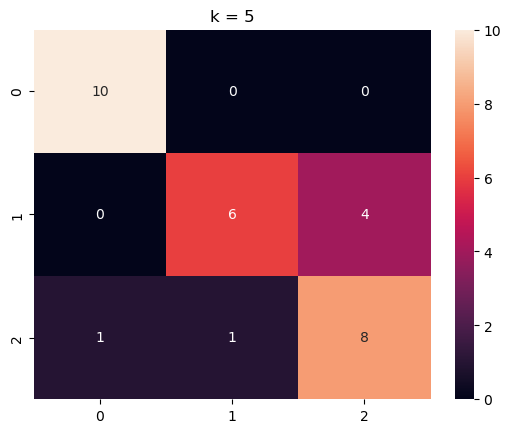

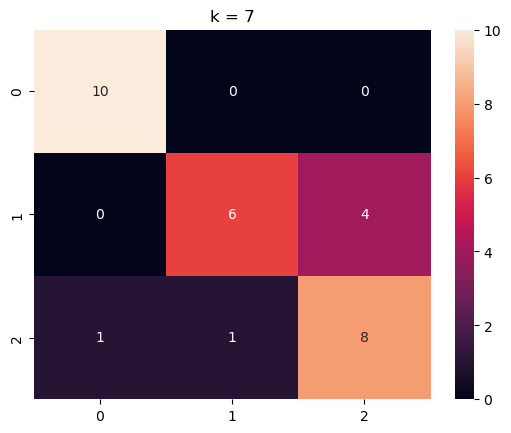

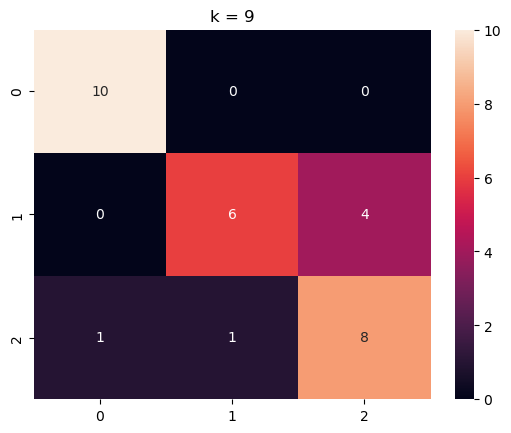

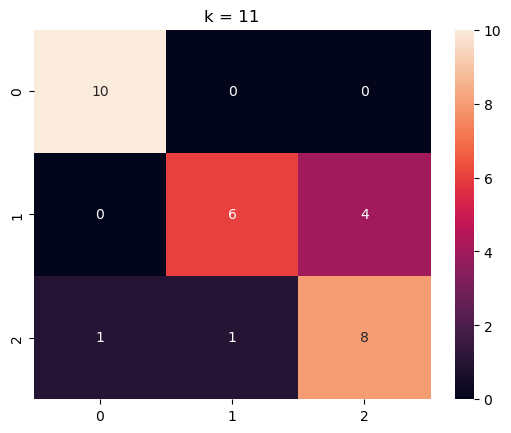

In [134]:
for i in range(len(Eq_cms)):
    plt.title("k = "+str(i+(i+1%2)))
    sns.heatmap(Eq_cms[i],annot=True,fmt="d")
    plt.show()

<h3 style="color:#2F4F4F; font-family: Didot, serif;">b. Performance du Modèle k-NN : Précision selon k</h3> 

In [135]:
#accuracy for each value of k
K = {}
for i in range(len(Eq_accuracys)):
    K[ i+(i+1%2) ] = Eq_accuracys[i]
    print("k = {} \t | \t accuracy = {}".format(str(i+(i+1%2)),Eq_accuracys[i]))

k = 1 	 | 	 accuracy = 0.8
k = 3 	 | 	 accuracy = 0.8
k = 5 	 | 	 accuracy = 0.8
k = 7 	 | 	 accuracy = 0.8
k = 9 	 | 	 accuracy = 0.8
k = 11 	 | 	 accuracy = 0.8


<h3 style="color:#2F4F4F; font-family: Didot, serif;">c. Optimisation de la Valeur de k : Courbe de Précision et Sélection du Modèle</h3> 

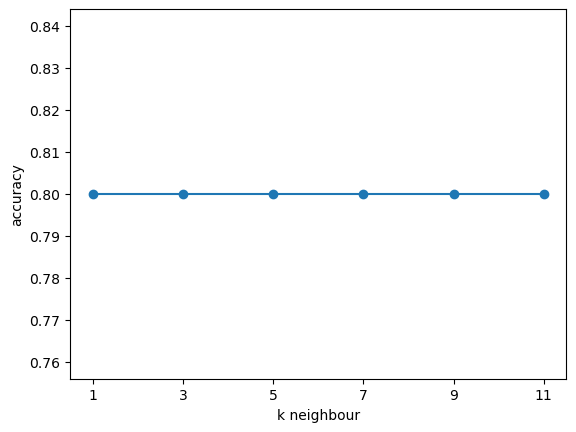

In [136]:
plt.plot(np.arange(1,13,2),np.array(Eq_accuracys),marker="o")
plt.xticks(np.arange(1, 13,2))
plt.xlabel('k neighbour')
plt.ylabel('accuracy')
plt.show()

In [137]:
def get_max_K(K):
    max_value = max(K.values())
    max_keys = [k for k, v in K.items() if v == max_value]
    return max_keys[0]

print("la valeur optimale de k pour ce probleme est: ",get_max_K(K))

la valeur optimale de k pour ce probleme est:  1


<h3 style="color:#00008B; font-family: Didot, serif;">2.2 Méthode supervisée (SVM : Support Vector Machines): </h3>

In [138]:
# Création du modèle SVM avec un noyau linéaire
Eq_svm_model = SVC(kernel='linear', random_state=42)

# Entraînement du modèle SVM
Eq_svm_model.fit(Eq_Xtrain, Eq_ytrain)

# Prédiction sur l'ensemble de test
Eq_ypred_svm = Eq_svm_model.predict(Eq_Xtest)

In [139]:
Eq_accuracy_svm = accuracy_score(Eq_ytest, Eq_ypred_svm)
print("Précision du SVM:", Eq_accuracy_svm)

# Calcul de la matrice de confusion
Eq_confmatrix_svm = confusion_matrix(Eq_ytest, Eq_ypred_svm)

Précision du SVM: 0.8


<h3 style="color:#2F4F4F; font-family: Didot, serif;">b.Visualisation de la Matrice de Confusion </h3>

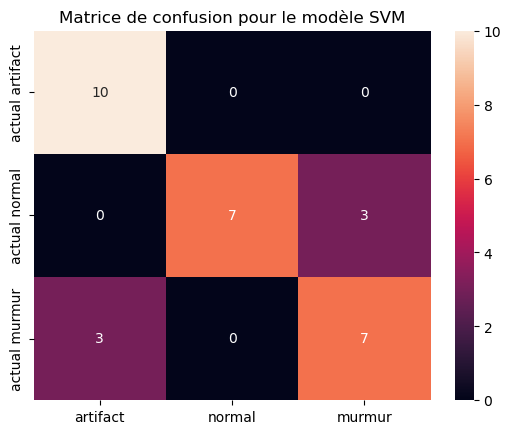

In [140]:
Eq_class_labelsX = ['artifact', 'normal', 'murmur']
Eq_class_labelsY = ['actual artifact', 'actual normal', 'actual murmur']

plt.title('Matrice de confusion pour le modèle SVM')
sns.heatmap(Eq_confmatrix_svm,annot=True,fmt="d" , xticklabels=Eq_class_labelsX, yticklabels=Eq_class_labelsY)
plt.show()


<h3 style="color:#00008B; font-family: Didot, serif;">2.3 Méthode supervisée (Random Forest): </h3>

In [141]:
# Création du modèle Random Forest
Eqrf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle Random Forest
Eqrf_model.fit(Eq_Xtrain, Eq_ytrain)

# Prédiction sur l'ensemble de test
Eq_ypred_rf = Eqrf_model.predict(Eq_Xtest)

In [142]:
Eq_accuracy_rf = accuracy_score(Eq_ytest, Eq_ypred_rf)
print("Précision de la Random Forest:", Eq_accuracy_rf)

# Calcul de la matrice de confusion
Eq_confmatrix_rf = confusion_matrix(Eq_ytest, Eq_ypred_rf)


Précision de la Random Forest: 0.7666666666666667


<h3 style="color:#2F4F4F; font-family: Didot, serif;">a.Visualisation de la Matrice de Confusion </h3>


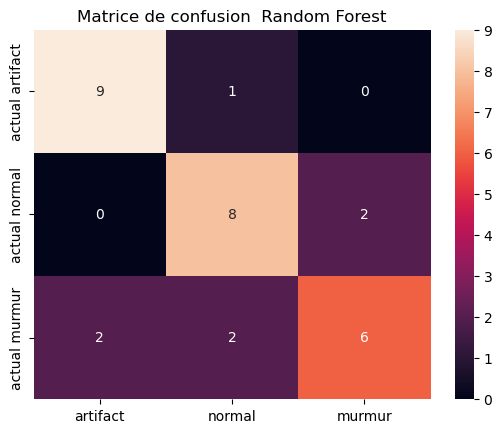

In [143]:
Eq_class_labelsX_rf  = ['artifact', 'normal', 'murmur']
Eq_class_labelsY_rf  = ['actual artifact', 'actual normal', 'actual murmur']


plt.title('Matrice de confusion  Random Forest')
sns.heatmap(Eq_confmatrix_rf,annot=True,fmt="d" ,xticklabels=Eq_class_labelsX_rf, yticklabels=Eq_class_labelsY_rf )
plt.show()

<h3 style="color:#00008B; font-family: Didot, serif;">3. Méthode non supervisée (K-Means) : </h3>

In [144]:
n_clusters = 3
Eq_kmeans = KMeans(n_clusters=n_clusters, random_state=0)

#ajuster le modèle et obtenir les clusters
Eq_ypred = Eq_kmeans.fit_predict(eq_X)

#obtenir une correspondance entre les clusters de K-means et les véritables étiquettes
Eq_ypred_label = correspondance(Eq_ypred, eq_y)


C:\Users\faizn_h\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\faizn_h\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [145]:
# Calcul de la matrice de confusion
Eq_cm = confusion_matrix(eq_y, Eq_ypred_label)

# Calcul du score de précision
Eq_accuracy = accuracy_score(eq_y, Eq_ypred_label)

<h3 style="color:#2F4F4F; font-family: Didot, serif;">a.Visualisation de la Matrice de Confusion </h3>

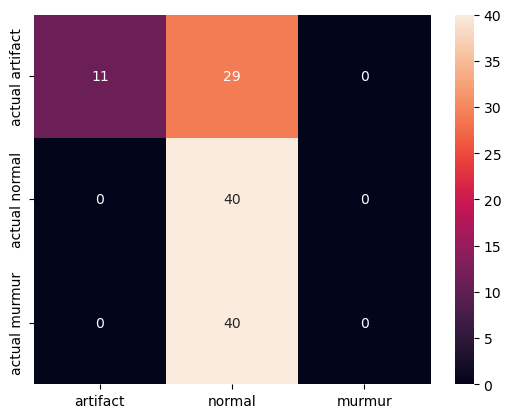


Score de précision : 0.425


In [146]:
Eq_class_labelsX = ['artifact', 'normal', 'murmur']
Eq_class_labelsY = ['actual artifact', 'actual normal', 'actual murmur']

sns.heatmap(Eq_cm,annot=True,fmt="d" , xticklabels=Eq_class_labelsX, yticklabels=Eq_class_labelsY )
plt.show()

print("\nScore de précision :", Eq_accuracy)


<h3 style="color:#00008B; font-family: Didot, serif;">4. Prétraitement Avancé : Application de l'ACP et t-SNE"  </h3>
<h3 style="color:#2F4F4F; font-family: Didot, serif;">a.ACP </h3>

In [147]:
# Standardisation des caractéristiques d'apprentissage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Utiliser le même scaler

# Application de l'ACP sur l'ensemble d'apprentissage
pca = PCA(n_components=0.99)  # ou un autre nombre de votre choix
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)  # Appliquer la même transformation

<h3 style="color:#00008B; font-family: Didot, serif;">4.1 Méthode supervisée (KNN : k nearest neighbors) : </h3> 

In [148]:
accuracys_pca = []
cms_pca = []
for i in range(1, 13, 2):
    neight_pca = KNeighborsClassifier(n_neighbors=i)
    neight_pca.fit(X_train_pca, y_train)  # Utilisation des données transformées par l'ACP et des bonnes étiquettes
    ypred_pca = neight_pca.predict(X_test_pca)  # Correction de la variable pour la prédiction
    accuracys_pca.append(accuracy_score(y_test, ypred_pca))  # Utilisation des bonnes étiquettes
    cms_pca.append(confusion_matrix(y_test, ypred_pca))

<h3 style="color:#2F4F4F; font-family: Didot, serif;">a.Visualisation de la Matrice de Confusion </h3> 

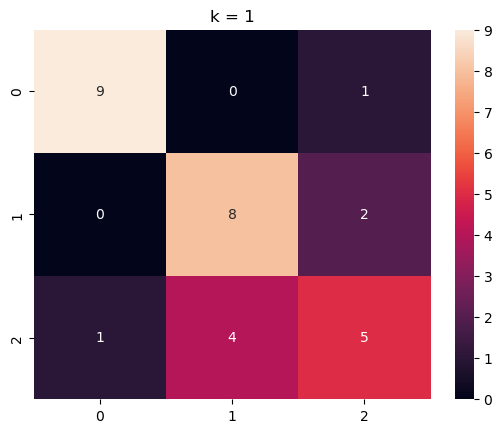

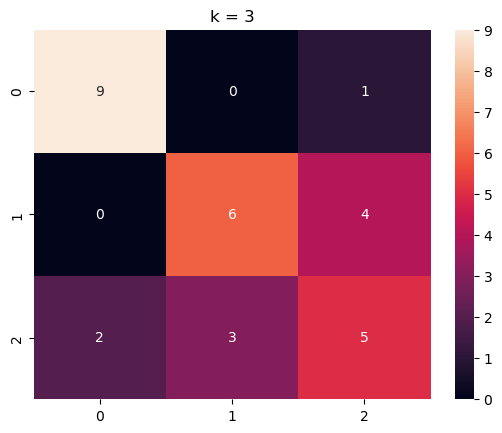

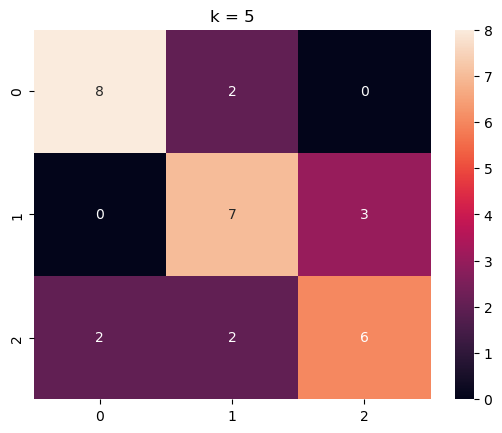

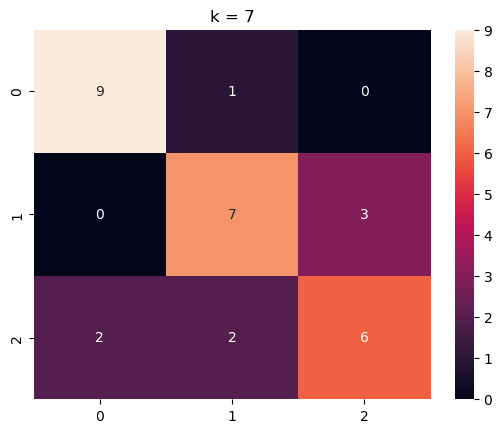

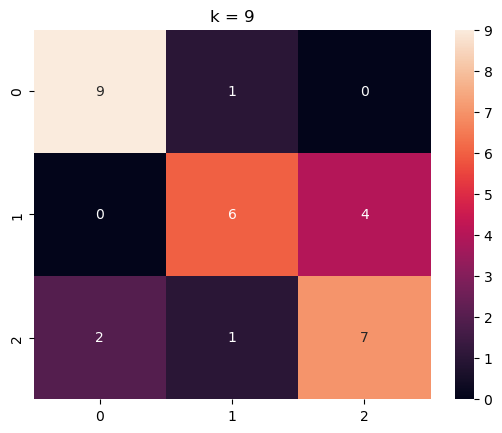

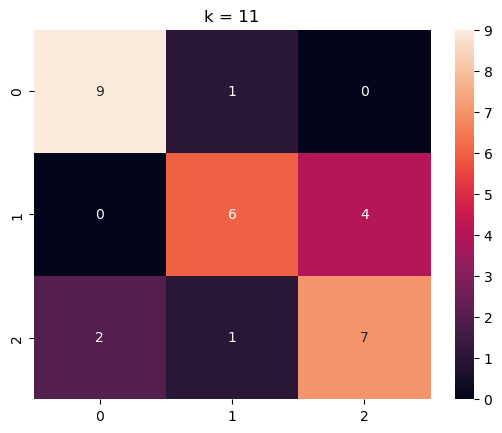

In [163]:
for i in range(len(cms_pca)):
    plt.title("k = "+str(i+(i+1%2)))
    sns.heatmap(cms_pca[i],annot=True,fmt="d")
    plt.show()

<h3 style="color:#2F4F4F; font-family: Didot, serif;">b. Performance du Modèle k-NN : Précision selon k</h3> 

In [169]:
#accuracy for each value of k
K = {}
for i in range(len(accuracys_pca)):
    K[ i+(i+1%2) ] = accuracys_pca[i]
    print("k = {} \t | \t accuracy = {}".format(str(i+(i+1%2)),accuracys_pca[i]))

k = 1 	 | 	 accuracy = 0.7333333333333333
k = 3 	 | 	 accuracy = 0.6666666666666666
k = 5 	 | 	 accuracy = 0.7
k = 7 	 | 	 accuracy = 0.7333333333333333
k = 9 	 | 	 accuracy = 0.7333333333333333
k = 11 	 | 	 accuracy = 0.7333333333333333


<h3 style="color:#00008B; font-family: Didot, serif;">4.2 Méthode non supervisée (K-Means) : </h3>

In [170]:
# Standardisation des caractéristiques
X_scaled = scaler.fit_transform(X)

# Application de l'ACP
K_pca = PCA(n_components=0.95)  # Conserver 95% de la variance
X_pca = K_pca.fit_transform(X_scaled)
n_clusters = 3
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=0)
ypred_pca = kmeans_pca.fit_predict(X_pca)
ypred_label_pca = correspondance(ypred_pca, y)


C:\Users\faizn_h\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\faizn_h\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


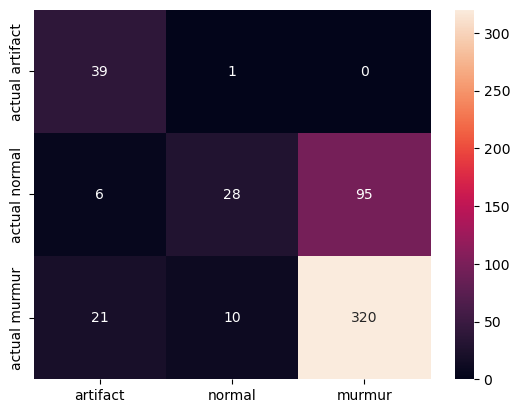


Score de précision : 0.7442307692307693


In [171]:
cm_Kpca = confusion_matrix(y, ypred_label_pca)
accuracy_Kpca = accuracy_score(y, ypred_label_pca)

sns.heatmap(cm_Kpca, annot=True, fmt="d", xticklabels=class_labelsX, yticklabels=class_labelsY)
plt.show()

print("\nScore de précision :", accuracy_Kpca)

<h3 style="color:#2F4F4F; font-family: Didot, serif;">b. t-SNE </h3>

In [172]:
n_components = 2  # 2 pour une visualisation en 2D, 3 pour 3D
tsne = TSNE(n_components=n_components, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

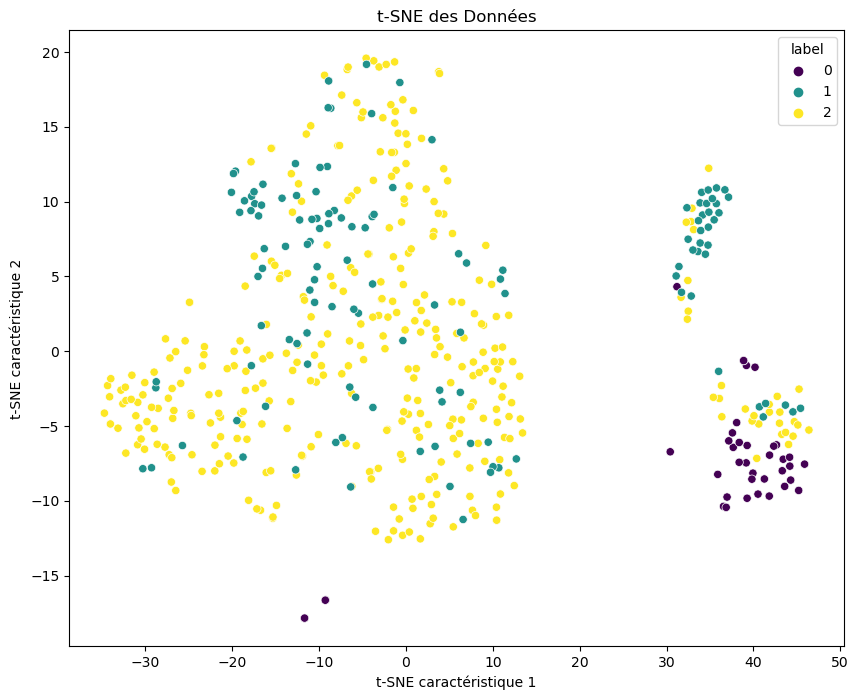

In [173]:
# Conversion des données t-SNE en DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = y  # Ajoutez vos étiquettes comme une colonne supplémentaire

# Visualisation en utilisant Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='label', palette='viridis')
plt.title('t-SNE des Données')
plt.xlabel('t-SNE caractéristique 1')
plt.ylabel('t-SNE caractéristique 2')
plt.show()

<h3 style="color:#00008B; font-family: Didot, serif;">4.3 Méthode supervisée (KNN : k nearest neighbors) : </h3> 

In [174]:
# Division en ensembles d'apprentissage et de test
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(X_tsne, y, test_size=0.25, random_state=31)

accuracys_tsne = []
cms_tsne = []
for i in range(1, 13, 2):
    knn_tsne = KNeighborsClassifier(n_neighbors=i)
    knn_tsne.fit(X_train_tsne, y_train_tsne)
    y_pred_tsne = knn_tsne.predict(X_test_tsne)
    accuracys_tsne.append(accuracy_score(y_test_tsne, y_pred_tsne))
    cms_tsne.append(confusion_matrix(y_test_tsne, y_pred_tsne))

<h3 style="color:#2F4F4F; font-family: Didot, serif;">a.Visualisation de la Matrice de Confusion </h3> 


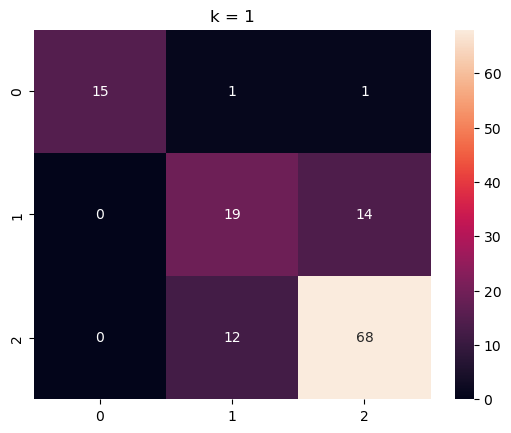

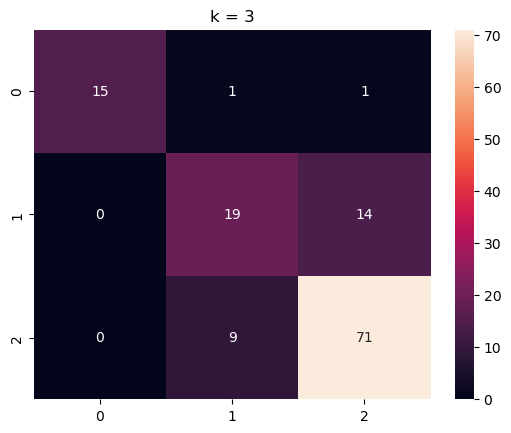

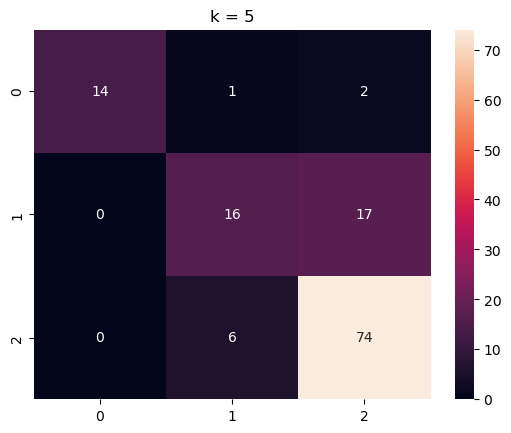

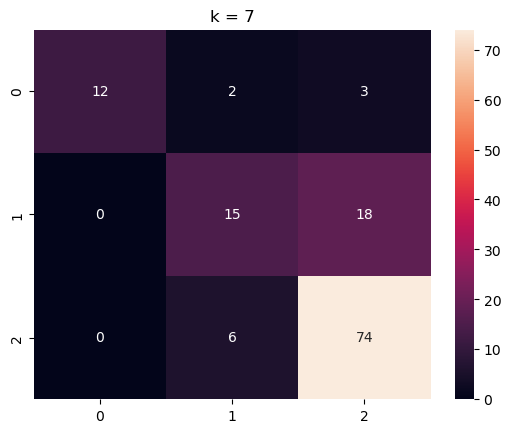

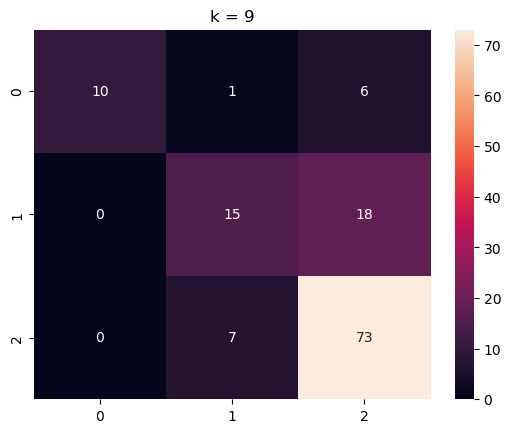

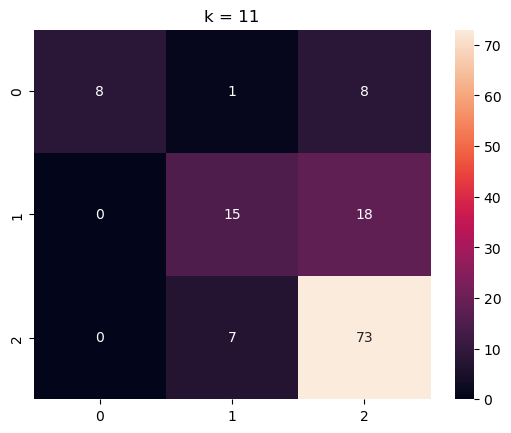

In [175]:
for i in range(len(cms_tsne)):
    plt.title("k = "+str(i+(i+1%2)))
    sns.heatmap(cms_tsne[i],annot=True,fmt="d")
    plt.show()

<h3 style="color:#2F4F4F; font-family: Didot, serif;">b. Performance du Modèle k-NN : Précision selon k</h3>

In [167]:
#accuracy for each value of k
K = {}
for i in range(len(accuracys_tsne)):
    K[ i+(i+1%2) ] = accuracys_tsne[i]
    print("k = {} \t | \t accuracy = {}".format(str(i+(i+1%2)),accuracys_tsne[i]))

k = 1 	 | 	 accuracy = 0.7846153846153846
k = 3 	 | 	 accuracy = 0.8076923076923077
k = 5 	 | 	 accuracy = 0.8
k = 7 	 | 	 accuracy = 0.7769230769230769
k = 9 	 | 	 accuracy = 0.7538461538461538
k = 11 	 | 	 accuracy = 0.7384615384615385
